In [1]:
import sys
sys.path.append('..')
import os
os.chdir('..')
import numpy as np
import torch
import torchaudio
import os.path
from util.arg_extractor import extract_args_from_json
from experiment_builders.vqvae_builder import VQVAEWORLDExperimentBuilder
from experiment_builders.vae_builder import VAEWORLDExperimentBuilder
from models.vqvae import VQVAE
from models.vae import VAE
from datasets.vcc_world_preprocessor import read_audio_and_extract_features, synthesize_from_WORLD_features
from datasets.vcc_world_dataset import VCCWORLDDataset
import util.torchaudio_transforms as transforms
import librosa.display
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")

In [2]:
dataset = VCCWORLDDataset('data', scale=True, eval=False)

In [55]:
args = extract_args_from_json('experiment_configs/vae_vcc_world.json')
args.eval_out_path='audio_out'
args.eval_audio_path = 'data/vcc2016_training/SM2/100041.wav' 

In [56]:
# Load audio
audio_path = os.path.expanduser(args.eval_audio_path)
spectra, aperiodicity, f0, energy = read_audio_and_extract_features(audio_path)
print(spectra.shape)

(447, 513)


(35760,)


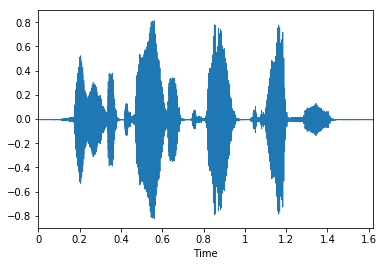

In [57]:
audio_in = synthesize_from_WORLD_features(f0, spectra, aperiodicity, energy)
print(audio_in.shape)
plt.figure()
librosa.display.waveplot(audio_in)

## VQVAE:

In [8]:
# Prepare model
vqvae_model = VQVAE(
    input_shape=(1, 1, args.input_len),
    encoder_arch=args.encoder,
    vq_arch=args.vq,
    generator_arch=args.generator,
    num_speakers=args.num_speakers,
    speaker_dim=args.speaker_dim,
    use_gated_convolutions=args.use_gated_convolutions)

# Select epoch
epoch = 12

# Load model from state
vqvae_experiment = VQVAEWORLDExperimentBuilder(network_model=vqvae_model,
                                        experiment_name=args.experiment_name,
                                        num_epochs=args.num_epochs,
                                        weight_decay_coefficient=args.weight_decay_coefficient,
                                        commit_coefficient=args.commit_coefficient,
                                        learning_rate=args.learning_rate,
                                        device=torch.device('cpu'),
                                        continue_from_epoch=epoch,
                                        train_data=None,
                                        val_data=None)

Building VQVAE.
Building Encoder with 6 downsampling layers.
torch.Size([1, 1, 513])
torch.Size([1, 32, 171])
torch.Size([1, 32, 171])
torch.Size([1, 64, 57])
torch.Size([1, 64, 57])
torch.Size([1, 64, 19])
torch.Size([1, 32, 19])
Building VQ layer.
VQ latent shape: torch.Size([1, 32, 19])
speaker_out shape: torch.Size([1, 32, 19])
Building Decoder/Generator with 7 upsampling layers.
torch.Size([1, 32, 19])
torch.Size([1, 32, 57])
torch.Size([1, 32, 57])
torch.Size([1, 16, 171])
torch.Size([1, 16, 171])
torch.Size([1, 8, 513])
torch.Size([1, 8, 513])
torch.Size([1, 1, 513])
/home/vaidas/Projects/mlpcw/experiments/vqvae_vcc_world /home/vaidas/Projects/mlpcw/experiments/vqvae_vcc_world/result_outputs
Loading model train_model, at epoch 12.


In [45]:
source_speaker_id = 1
args.eval_speaker_id = 1
# Prepare speaker tensor
speaker_id = torch.tensor(args.eval_speaker_id, dtype=torch.long)

In [46]:
spectra_scaled = dataset.scale_spectra(torch.tensor(spectra)).unsqueeze(1)
spectra_out = vqvae_experiment.convert(x=spectra_scaled, y=speaker_id)

spectra_out = dataset.scale_spectra_back(spectra_out)
f0_converted = dataset.convert_f0(torch.tensor(f0), source_speaker_id, args.eval_speaker_id)

# Reshape back
spectra_out = spectra_out.squeeze(1)

print(spectra_out.shape)

torch.Size([809, 513])


## VAE

In [21]:
vae_model = VAE(
    input_shape=(1, 1, args.input_len),
    encoder_arch=args.encoder,
    generator_arch=args.generator,
    latent_dim=args.latent_dim,
    num_speakers=args.num_speakers,
    speaker_dim=args.speaker_dim,
    use_gated_convolutions=args.use_gated_convolutions)

# Select epoch
epoch = 18

vae_experiment = VAEWORLDExperimentBuilder(network_model=vae_model,
                                    experiment_name=args.experiment_name,
                                    num_epochs=args.num_epochs,
                                    weight_decay_coefficient=args.weight_decay_coefficient,
                                    learning_rate=args.learning_rate,
                                    device=torch.device('cpu'),
                                    continue_from_epoch=epoch,
                                    train_data=None,
                                    val_data=None)

Building VAE.
Building Encoder with 6 downsampling layers.
torch.Size([1, 1, 513])
torch.Size([1, 32, 171])
torch.Size([1, 32, 171])
torch.Size([1, 64, 57])
torch.Size([1, 64, 57])
torch.Size([1, 128, 19])
torch.Size([1, 128, 19])
mean shape: torch.Size([1, 64])
logvar shape: torch.Size([1, 64])
latent shape: torch.Size([1, 64])
latent_out shape: torch.Size([1, 2432])
speaker_out shape: torch.Size([1, 2432])
latent_out reshaped: torch.Size([1, 128, 19])
Building Decoder/Generator with 7 upsampling layers.
torch.Size([1, 128, 19])
torch.Size([1, 32, 57])
torch.Size([1, 32, 57])
torch.Size([1, 16, 171])
torch.Size([1, 16, 171])
torch.Size([1, 8, 513])
torch.Size([1, 8, 513])
torch.Size([1, 1, 513])
/home/vaidas/Projects/mlpcw/experiments/vae_vcc_world /home/vaidas/Projects/mlpcw/experiments/vae_vcc_world/result_outputs
Loading model train_model, at epoch 18.


In [62]:
source_speaker_id = 4
args.eval_speaker_id = 9
# Prepare speaker tensor
speaker_id = torch.tensor(args.eval_speaker_id, dtype=torch.long)

In [63]:
spectra_scaled = dataset.scale_spectra(torch.tensor(spectra)).unsqueeze(1)
spectra_out = vae_experiment.convert(x=spectra_scaled, y=speaker_id)

spectra_out = dataset.scale_spectra_back(spectra_out)
f0_converted = dataset.convert_f0(torch.tensor(f0), source_speaker_id, args.eval_speaker_id)

# Reshape back
spectra_out = spectra_out.squeeze(1)

print(spectra_out.shape)

torch.Size([447, 513])


##### Test on random noise
spectra_out = torch.tanh(torch.randn((997, 513))*2-1)
print(spectra_out.shape)
spectra_out = dataset.scale_spectra_back(spectra_out)

(35760,)


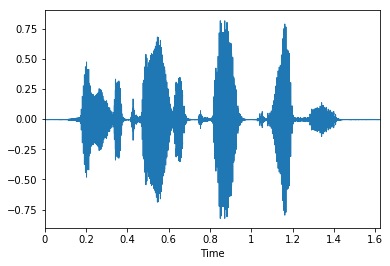

In [64]:
audio_out = synthesize_from_WORLD_features(f0_converted.numpy(), spectra_out.numpy(), aperiodicity, energy)
audio_out = np.clip(audio_out, a_min=-0.9, a_max=0.9)
print(audio_out.shape)
plt.figure()
librosa.display.waveplot(audio_out)

In [65]:
out_path = os.path.expanduser(args.eval_out_path)
out_filename = '{}_{}_{}.wav'.format(os.path.basename(args.eval_audio_path).split('.')[0], args.eval_speaker_id, epoch)
out_file_path = os.path.join(out_path, out_filename)
print(out_file_path)

# Save as audio
torchaudio.save(filepath=out_file_path, src=torch.tensor(audio_out.copy()), sample_rate=16000)

audio_out/100041_9_18.wav
